# At this point, I had my cleaning and transformations down pat

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score
%matplotlib inline
#Imports

In [6]:
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')

In [7]:
Exter_dict = {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
Lot_dict = {'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3}
Bsmt_dict = {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
Bsmt_ex_dict = {'NA': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
Func_dict = {'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 
             'Mod': 4, 'Min2': 5, 'Min1': 6, 'Typ': 7}
Fence_dict = {'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

train['Exter Qual'].replace(Exter_dict, inplace = True)
test['Exter Qual'].replace(Exter_dict, inplace = True)

train['Exter Cond'].replace(Exter_dict, inplace = True)
test['Exter Cond'].replace(Exter_dict, inplace = True)

train['Heating QC'].replace(Exter_dict, inplace = True)
test['Heating QC'].replace(Exter_dict, inplace = True)

train['Kitchen Qual'].replace(Exter_dict, inplace = True)
test['Kitchen Qual'].replace(Exter_dict, inplace = True)

train['Bsmt Qual'].replace(Bsmt_dict, inplace = True)
test['Bsmt Qual'].replace(Bsmt_dict, inplace = True)

train['Bsmt Cond'].replace(Bsmt_dict, inplace = True)
test['Bsmt Cond'].replace(Bsmt_dict, inplace = True)

train['Bsmt Exposure'].replace(Bsmt_ex_dict, inplace = True)
test['Bsmt Exposure'].replace(Bsmt_ex_dict, inplace = True)

train['Functional'].replace(Func_dict, inplace = True)
test['Functional'].replace(Func_dict, inplace = True)

train['Fireplace Qu'].replace(Bsmt_dict, inplace = True)
test['Fireplace Qu'].replace(Bsmt_dict, inplace = True)

train['Garage Qual'].replace(Bsmt_dict, inplace = True)
test['Garage Qual'].replace(Bsmt_dict, inplace = True)

train['Garage Cond'].replace(Bsmt_dict, inplace = True)
test['Garage Cond'].replace(Bsmt_dict, inplace = True)

train['Pool QC'].replace(Bsmt_dict, inplace = True)
test['Pool QC'].replace(Bsmt_dict, inplace = True)

train['Fence'].replace(Fence_dict, inplace = True)
test['Fence'].replace(Fence_dict, inplace = True)

train['Lot Shape'].replace(Lot_dict, inplace = True)
test['Lot Shape'].replace(Lot_dict, inplace = True)




In [8]:
#Some more dummy variables than normal for my Great Experiment
dummy_vars = ['Exterior 1st','House Style', 'Central Air', 'Foundation', 'MS Zoning', 'Street', 'Alley', 'Neighborhood']

In [9]:
train = pd.get_dummies(train, columns = dummy_vars)
test = pd.get_dummies(test, columns = dummy_vars)

# Feature Engineering


In [10]:
train['Garage_Total'] = train['Garage Yr Blt'] * train['Garage Cars'] * train['Garage Area'] * train['Garage Qual'] * train['Garage Cond']
test['Garage_Total'] = train['Garage Yr Blt'] * train['Garage Cars'] * train['Garage Area'] * train['Garage Qual'] * train['Garage Cond']

In [11]:
train['Bsmt_Total'] = train['Bsmt Qual'] * train['Bsmt Cond'] * train['Bsmt Exposure'] * train['Total Bsmt SF']
test['Bsmt_Total'] = train['Bsmt Qual'] * train['Bsmt Cond'] * train['Bsmt Exposure'] * train['Total Bsmt SF']


In [12]:
train['TotRms_GrLiv'] = train['TotRms AbvGrd'] * train['Gr Liv Area']
test['TotRms_GrLiv'] = test['TotRms AbvGrd'] * test['Gr Liv Area']

In [13]:
train['id_yrsld'] = train['Id'] * train['Yr Sold']
test['id_yrsld'] = test['Id'] * test['Yr Sold']

In [14]:
train['Exter_Overall'] = train['Exter Qual'] * train['Overall Qual']
test['Exter_Overall'] = test['Exter Qual'] * test['Overall Qual']

In [15]:
#Notice how I did it to test, not train
features_init = [c for c in test._get_numeric_data().columns if not c in ['SalePrice']]

In [16]:
#Had to remove all the NaNs for this experiment
for n in features_init:
    if n in train.columns:
        train[n].fillna(0, inplace = True)
    if n in test.columns:
        test[n].fillna(0, inplace = True)


In [17]:
features_init.remove("Exterior 1st_PreCast")
#Some of the dummy variables only appeared in test, not train, so I had to remove it to keep consistency

In [18]:
train[features_init].isnull().sum().sum()

0

In [19]:
test[features_init].isnull().sum().sum()

0

In [20]:

def r2_adj(r2,X):
    return 1 - ((1-r2)*(len(X)-1))/(len(X)-len(X.columns)-1)

def print_metrics(model_pass, X_pass,y_pass ):
    residual = model_pass.predict(X_pass) - y_pass
    print(f"Mean squared error: {(residual**2).mean()}")
    r2 = model_pass.score(X_pass, y_pass)
    print(f"R Squared value: {r2}")
    print(f"Adjusted R Squared Value: {r2_adj(r2, X)}")
    print(f"Root mean squared error: {np.sqrt((residual**2).mean())}")
    print(f'Residual sum of squares: {(residual**2).sum()}')
    print(f"Residual mean: {residual.mean()}")

In [21]:
def RT_MSE(model_pass, X_pass, y_pass):
    return np.sqrt(((model_pass.predict(X_pass) - y_pass)**2).mean())

In [22]:
train.shape

(2051, 148)

In [23]:
test.shape

(879, 142)

## THE IDEA: 
Put everything numeric into a list except for SalePrice. Then loop through, adding them one at a time to another list, and put them through their paces. Find the model and the list of features with the best combination of things, completely automatically. The metrics to use? I'll use a couple. R^2 is one, Root mean squared error is another

In [24]:
features = []


In [25]:
len(features_init)

119

In [26]:
#features_init.sample(4)

In [27]:
features_init = pd.Series(features_init)

In [28]:
features_init.sample(1)


85    Street_Pave
dtype: object

In [29]:
features_init.shape

(119,)

In [30]:
train[features_init].shape

(2051, 119)

In [31]:
test[features_init].shape

(879, 119)

I'll need to square the number of items n to get the total possible configurations

Pseudocode time!

ideal_r2 = 0

r2_features = []

ideal_rmse = 99999999

rmse_features = []

loop n from 1 to length of features_init

    counter = 0
    
    loop while counter < length of features * n
        unique_features = []
        sample features_init n times
        do all my linear regression math here, using the ridge regularization method
        calculate cross_val_score
        calculate rmse
        if r2 > ideal_r2
            r2_features = features
        if rmse < ideal_rmse
            rmse_features = features
        if set of features not in unique_features
            add them to unique_features
            counter++
        
        
Ok let's get this in Python

# WARNING: DO NOT RUN. It takes hours

In [32]:
# ideal_r2 = 0
# r2_features = []
# ideal_rmse = 99999999
# rmse_features = []
# y = train['SalePrice']
# feature_length = len(features_init)#Every possible numeric feature
# print('start')
# for n in range(20, 50): # I didn't actually want to run it for 24 hours.
#     counter = 1 #To be comprehensive, the range would be 1 to feature_length. Tuning.
#     while counter <= (feature_length * n):
#         unique_features = []
#         features = features_init.sample(n) #Random sample of n features
#         X = train[features]
        
#         X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42)
#         model_ridge = RidgeCV(cv = 5)
#         ss = StandardScaler() #Split and fit
#         ss.fit(X_train)
#         X_train_sc = ss.transform(X_train)
#         X_test_sc = ss.transform(X_test)
#         model_ridge.fit(X_train_sc, y_train)
        
#         r2_temp = model_ridge.score(X_test_sc, y_test) #R2 value
#         rmse_temp = RT_MSE(model_ridge, X_test_sc, y_test) #Root mean squared error
        
#         if r2_temp > ideal_r2: #Tested two different values for the minimum
#             r2_features = features
#             ideal_r2 = r2_temp
#         if rmse_temp < ideal_rmse:
#             rmse_features = features
#             ideal_rmse = rmse_temp
            
#         if not features in unique_features: #Makes sure every combination is tried
#             unique_features.append(features)
#             counter += 1
            
#     print(n)   #Track progress      
# print(ideal_r2)
# print(ideal_rmse)

In [33]:
# I don't quite understand but hey that's machine learning for ya
features_final = ['Kitchen Qual', 'Exter Qual', 'Bsmt_Total', 'Neighborhood_NWAmes',
       'Foundation_Stone', 'Neighborhood_Blueste', 'Neighborhood_Mitchel',
       'Fireplaces', 'Wood Deck SF', 'Garage Cond', 'Mas Vnr Area',
       'House Style_1Story', 'Misc Val', '2nd Flr SF', 'Mo Sold',
       '1st Flr SF', 'Bsmt Full Bath', 'Neighborhood_Greens',
       'Exterior 1st_AsbShng', 'Neighborhood_IDOTRR',
       'Exterior 1st_AsphShn', 'Exterior 1st_HdBoard', 'MS SubClass',
       'Overall Cond', 'Garage_Total', 'Neighborhood_OldTown',
       'MS Zoning_RM', 'House Style_2.5Unf', 'Functional',
       'Foundation_Slab', 'Yr Sold', 'Neighborhood_SWISU', '3Ssn Porch',
       'Year Built', 'Lot Area', 'Overall Qual', 'MS Zoning_RH',
       'House Style_1.5Unf', 'Open Porch SF', 'Neighborhood_MeadowV',
       'Lot Frontage', 'Exterior 1st_CemntBd', 'Bsmt Qual',
       'Neighborhood_Gilbert', 'Exterior 1st_VinylSd']

#Using Lasso with The Experiment. I only realized belatedly that LASSO would self-remove things, defeating the purpose

In [34]:
features_final2 = ['Foundation_BrkTil', 'Exter_Overall', 'House Style_2Story',
 'Exterior 1st_BrkFace' ,'Bsmt Half Bath', 'Neighborhood_Sawyer',
 'Neighborhood_BrDale', 'House Style_SFoyer', 'Neighborhood_BrkSide',
 'Exterior 1st_AsbShng' ,'MS Zoning_RM', 'Bsmt Full Bath' ,'Kitchen Qual',
 'Alley_Pave', 'Mas Vnr Area', 'MS Zoning_I (all)', 'BsmtFin SF 2', 'Lot Area',
 'House Style_SLvl', 'Total Bsmt SF', 'Exterior 1st_CemntBd',
 'Foundation_Slab' ,'Exter Qual', 'Exterior 1st_MetalSd', 'Overall Qual',
 'Neighborhood_NridgHt', 'TotRms_GrLiv' ,'Alley_Grvl', 'Foundation_CBlock',
 'Overall Cond', '3Ssn Porch', 'Neighborhood_Blmngtn', 'Neighborhood_Veenker',
 'Foundation_PConc', 'Misc Val', 'Garage Area', 'Functional', 'MS Zoning_RL',
 'Gr Liv Area', 'Bsmt Qual', 'MS SubClass', 'Open Porch SF',
 'Neighborhood_Crawfor', 'Neighborhood_Gilbert', 'Neighborhood_StoneBr',
 'Bsmt_Total']

#Using Ridge with The Experiment instead. Better results, too...somehow

In [35]:
features_final2.sort()
features_final2

['3Ssn Porch',
 'Alley_Grvl',
 'Alley_Pave',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Bsmt Qual',
 'BsmtFin SF 2',
 'Bsmt_Total',
 'Exter Qual',
 'Exter_Overall',
 'Exterior 1st_AsbShng',
 'Exterior 1st_BrkFace',
 'Exterior 1st_CemntBd',
 'Exterior 1st_MetalSd',
 'Foundation_BrkTil',
 'Foundation_CBlock',
 'Foundation_PConc',
 'Foundation_Slab',
 'Functional',
 'Garage Area',
 'Gr Liv Area',
 'House Style_2Story',
 'House Style_SFoyer',
 'House Style_SLvl',
 'Kitchen Qual',
 'Lot Area',
 'MS SubClass',
 'MS Zoning_I (all)',
 'MS Zoning_RL',
 'MS Zoning_RM',
 'Mas Vnr Area',
 'Misc Val',
 'Neighborhood_Blmngtn',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_Crawfor',
 'Neighborhood_Gilbert',
 'Neighborhood_NridgHt',
 'Neighborhood_Sawyer',
 'Neighborhood_StoneBr',
 'Neighborhood_Veenker',
 'Open Porch SF',
 'Overall Cond',
 'Overall Qual',
 'TotRms_GrLiv',
 'Total Bsmt SF']

In [37]:
train['3Ssn Porch'].value_counts()

0      2025
153       3
168       3
144       2
176       1
86        1
96        1
120       1
140       1
150       1
162       1
407       1
323       1
182       1
216       1
224       1
290       1
304       1
508       1
245       1
255       1
180       1
Name: 3Ssn Porch, dtype: int64

C:\Users\NICK\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


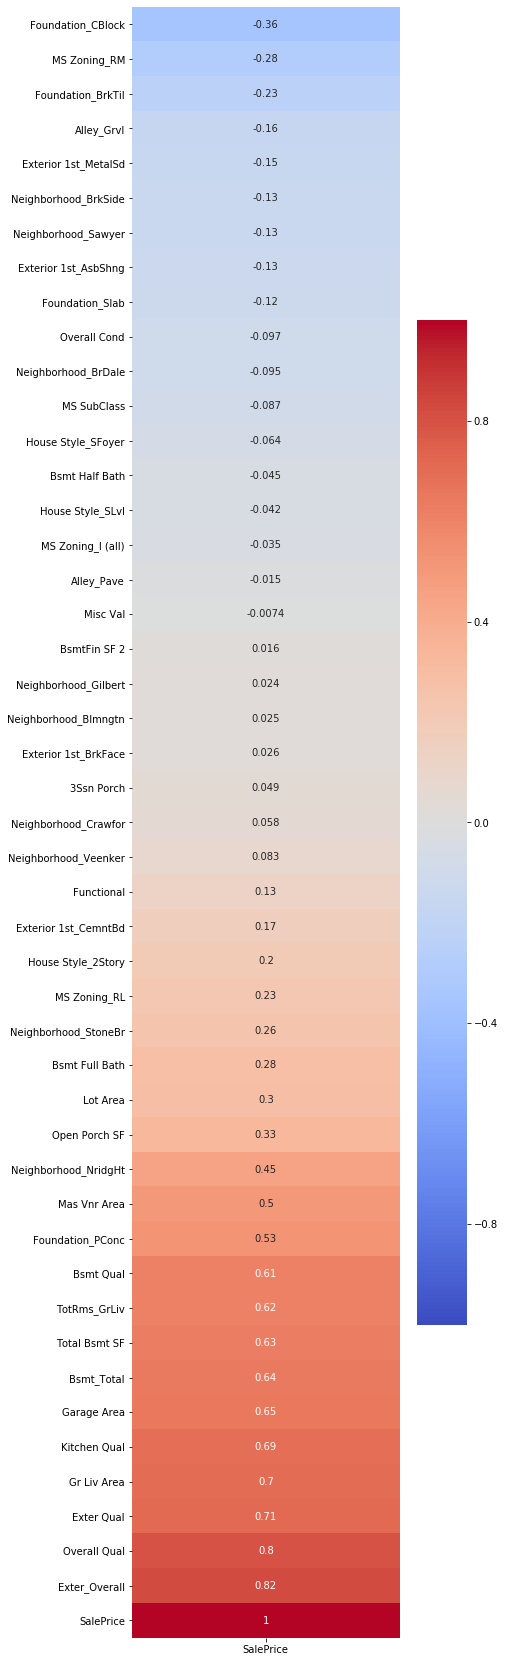

In [38]:
thing = train[features_final2]
thing['SalePrice'] = train['SalePrice']
plt.figure(figsize = (6,30))
sns.heatmap(thing.corr()[['SalePrice']].sort_values('SalePrice'), vmin = -1, annot = True, cmap = 'coolwarm')
#It had every combination of variables possible, and it chose this. Huh.

C:\Users\NICK\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


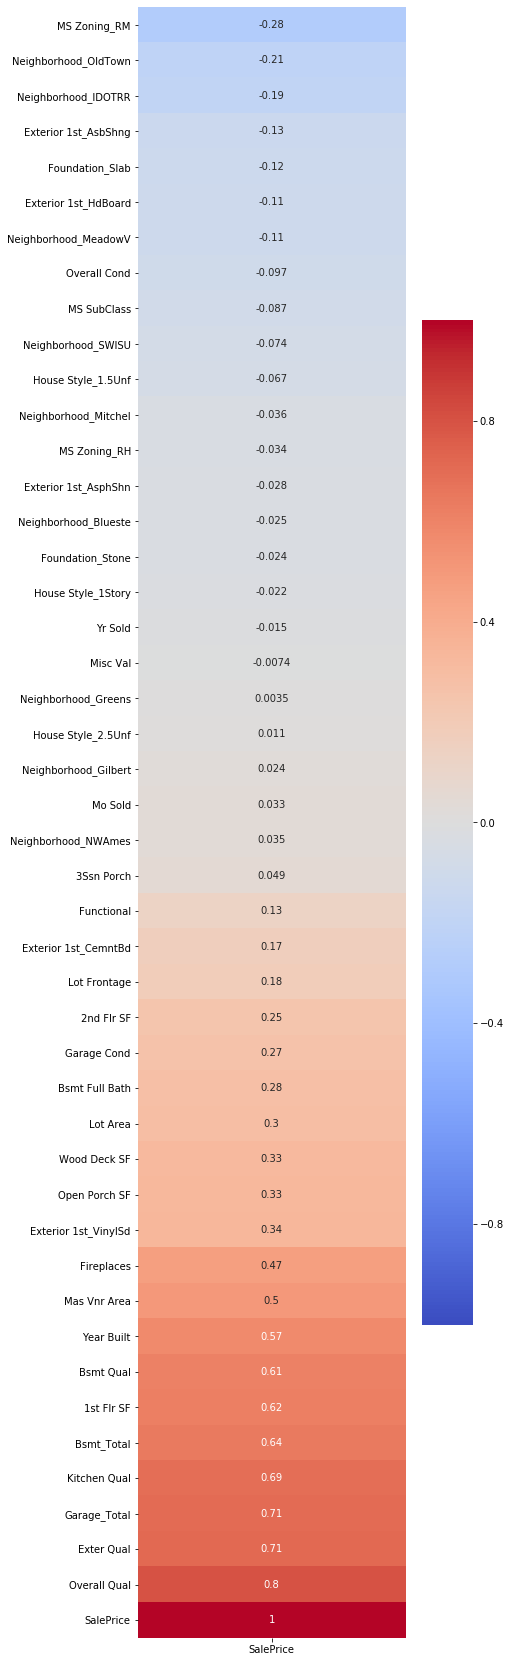

In [39]:
thing = train[features_final]
thing['SalePrice'] = train['SalePrice']
plt.figure(figsize = (6,30))
sns.heatmap(thing.corr()[['SalePrice']].sort_values('SalePrice'), vmin = -1, annot = True, cmap = 'coolwarm')
#It had every combination of variables possible, and it chose this. Huh.

In [40]:
train[features_final2].shape

(2051, 46)

In [41]:
test[features_final2].shape

(879, 46)

In [42]:
len(features_final2)

46

# Got my features. Time to model

In [43]:
X = train[features_final2]
y = train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42)
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)
model_ridge = RidgeCV() #Ridge actually seemed to give me a better score. Go figure
model_lr = LinearRegression()


In [44]:
model_ridge.fit(X_train_sc, y_train_log)
model_lr.fit(X_train, y_train_log)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [45]:
model_lr.score(X_train, y_train_log)

0.8740043731008624

In [46]:
model_lr.score(X_test, y_test_log)

0.8678408074950876

In [47]:
cross_val_score(model_lr, X_train, y_train_log, cv = 5).mean()

0.8406424180093325

In [48]:
model_ridge.score(X_train_sc, y_train_log)

0.8740042131699212

In [49]:
model_ridge.score(X_test_sc, y_test_log)

0.8678526807456377

In [50]:
cross_val_score(model_ridge, X_train_sc, y_train_log, cv = 5).mean()

0.8406775696709916

# The scores between the Ridge and the basic LinearRegression were very similar, so I don't know how much correction Ridge is even doing 

In [51]:
y_pred = model_lr.predict(X_test)

In [52]:
X_test.shape

(513, 46)

In [53]:
residual_lr = y_test - y_pred

In [54]:
np.sqrt((residual_lr**2).mean())

198776.12971480875

In [55]:
y_pred_log = np.exp(model_ridge.predict(X_test_sc))

In [56]:
residual_log = y_test - y_pred_log

In [57]:
np.sqrt((residual_log**2).mean())

24292.63990012225

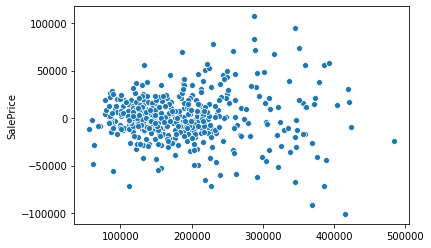

In [58]:
sns.scatterplot(y_pred_log, residual_log)

In [59]:
r2_score(y_test, y_pred_log)
#Not a bad score! Any more than that and I'd be exceptionally worried about overfitting

0.9038876259889057

In [60]:
X_test_real = test[features_final2]

In [61]:
X_test_real.shape

(879, 46)

In [62]:
Z_ss_test_test = pd.DataFrame(ss.fit_transform(X_test_real))

In [ ]:
y_pred_final = np.exp(model_ridge.predict(Z_ss_test_test))

In [ ]:
y_pred_final.shape

In [ ]:
test['SalePrice'] = y_pred_final

In [ ]:
submission = test[['Id', 'SalePrice']]

In [ ]:
submission.to_csv("Submission5.csv", index = False)